In [1]:
import requests

In [2]:
url = "https://api.yelp.com/v3/businesses/search"
url_params = {
    "term": "coffee",
    "location": "San Francisco, CA",
    "limit": 20,
    "categories": "Coffee Roasteries",
    "sort_by": "rating",
#     "attributes": "hot_and_new"
}

with open("api_key.txt", "r") as f:
    api_key = f.read()
headers = {
    "Authorization": f"Bearer {api_key}",
}

In [3]:
response = requests.get(url, headers=headers, params=url_params)

In [4]:
response

<Response [200]>

In [5]:
d = response.json()

In [6]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

sns.set()
ox.config(use_cache=True, log_console=True)

2022-09-04 16:50:54 Configured OSMnx 1.1.2
2022-09-04 16:50:54 HTTP response caching is on


In [7]:
sf = gpd.read_file("/Users/katherinementzer/SFUSD/Census 2010_ Blocks for San Francisco/geo_export_d4e9e90c-ff77-4dc9-a766-6a1a7f7d9f9c.shp")

In [8]:
latitudes = [d.get("businesses")[x].get("coordinates").get("latitude") for x in range(url_params["limit"])]
longitudes = [d.get("businesses")[x].get("coordinates").get("longitude") for x in range(url_params["limit"])]
geom = [Point(xy) for xy in zip(longitudes, latitudes)]
name = [d.get("businesses")[x].get("name") for x in range(url_params["limit"])]
df = gpd.GeoDataFrame(name, columns=["name"], geometry=geom)
df

,name,geometry
0,Flywheel Coffee Roasters,POINT (-122.45351 37.76968)
1,Blue Danube Coffee House,POINT (-122.46251 37.78323)
2,Diamond Coffee N Pastry,POINT (-122.47017 37.78290)
3,Rise & Grind Coffee and Tea,POINT (-122.46607 37.77372)
4,The Coffee Movement,POINT (-122.41030 37.79483)
5,Beanery,POINT (-122.46639 37.76383)
6,Andytown Coffee Roasters,POINT (-122.50228 37.75680)
7,Not Latte,POINT (-122.46441 37.78478)
8,The Mill,POINT (-122.43775 37.77648)
9,Castro Coffee Company,POINT (-122.43497 37.76219)


In [9]:
poly = Polygon([
    (-122.360, 37.81),
    (-122.515, 37.81),
    (-122.515, 37.707),
    (-122.360, 37.707)
])
df = df[[poly.contains(x) for x in df.geometry]]
df = df.set_crs("epsg:4326").head(10)
df

,name,geometry
0,Flywheel Coffee Roasters,POINT (-122.45351 37.76968)
1,Blue Danube Coffee House,POINT (-122.46251 37.78323)
2,Diamond Coffee N Pastry,POINT (-122.47017 37.78290)
3,Rise & Grind Coffee and Tea,POINT (-122.46607 37.77372)
4,The Coffee Movement,POINT (-122.41030 37.79483)
5,Beanery,POINT (-122.46639 37.76383)
6,Andytown Coffee Roasters,POINT (-122.50228 37.75680)
7,Not Latte,POINT (-122.46441 37.78478)
8,The Mill,POINT (-122.43775 37.77648)
9,Castro Coffee Company,POINT (-122.43497 37.76219)


(37.707, 37.81)

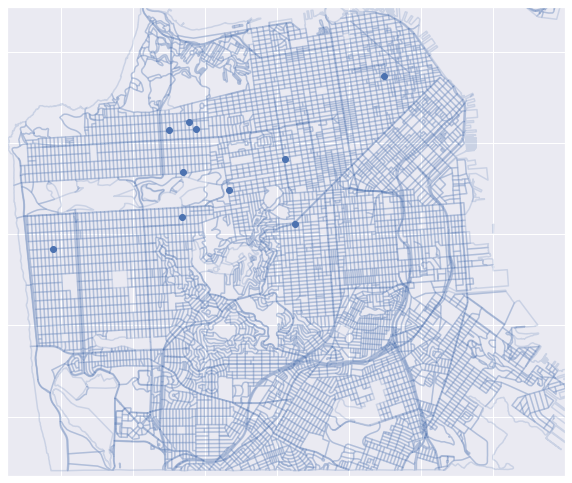

In [10]:
plt.figure(figsize=(10,10))
ax = plt.gca()
df.plot(ax=ax)
sf.loc[sf.awater10 == 0].boundary.plot(ax=ax, alpha=.2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(-122.515,-122.360)
ax.set_ylim(37.707,37.81)
# ax.set_xlim(-122.525,-122.350)
# ax.set_ylim(37.70,37.84)

In [11]:
g = ox.graph.graph_from_bbox(37.81,37.707, -122.360, -122.515, network_type="bike")

2022-09-04 16:50:56 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-09-04 16:50:56 Projected GeoDataFrame to epsg:4326
2022-09-04 16:50:56 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-09-04 16:50:56 Projected GeoDataFrame to epsg:4326
2022-09-04 16:50:56 Requesting data within polygon from API in 1 request(s)
2022-09-04 16:50:57 Retrieved response from cache file "cache/1f8cb5a2878bfbadd9e4af2326109b043ea35844.json"
2022-09-04 16:50:57 Got all network data within polygon from API in 1 request(s)
2022-09-04 16:50:57 Creating graph from downloaded OSM data...
2022-09-04 16:50:59 Created graph with 96821 nodes and 180972 edges
2022-09-04 16:51:01 Added length attributes to graph edges
2022-09-04 16:51:01 Identifying all nodes that lie outside the polygon...
2022-09-04 16:51:04 Created nodes GeoDataFrame from graph
2022-09-04 16:51:07 Created r-tree spatial index for 96821 geo

In [12]:
g = ox.distance.add_edge_lengths(g)

2022-09-04 16:51:28 Added length attributes to graph edges


In [13]:
g = ox.speed.add_edge_speeds(g)
g = ox.speed.add_edge_travel_times(g)

2022-09-04 16:51:29 Created edges GeoDataFrame from graph
2022-09-04 16:51:32 Created edges GeoDataFrame from graph


In [14]:
df.loc[:, "nearest_node"] = df.geometry.apply(lambda pt: ox.distance.nearest_nodes(g, pt.x, pt.y))
df

2022-09-04 16:51:32 Created nodes GeoDataFrame from graph
2022-09-04 16:51:32 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph
2022-09-04 16:51:33 Created nodes GeoDataFrame from graph


,name,geometry,nearest_node
0,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720
1,Blue Danube Coffee House,POINT (-122.46251 37.78323),65351072
2,Diamond Coffee N Pastry,POINT (-122.47017 37.78290),65356292
3,Rise & Grind Coffee and Tea,POINT (-122.46607 37.77372),5432250152
4,The Coffee Movement,POINT (-122.41030 37.79483),65310923
5,Beanery,POINT (-122.46639 37.76383),65297590
6,Andytown Coffee Roasters,POINT (-122.50228 37.75680),65294075
7,Not Latte,POINT (-122.46441 37.78478),65302771
8,The Mill,POINT (-122.43775 37.77648),5433622906
9,Castro Coffee Company,POINT (-122.43497 37.76219),5438557792


2022-09-04 16:51:33 Begin plotting the graph...
2022-09-04 16:51:36 Created edges GeoDataFrame from graph
2022-09-04 16:51:40 Created nodes GeoDataFrame from graph
2022-09-04 16:51:43 Finished plotting the graph


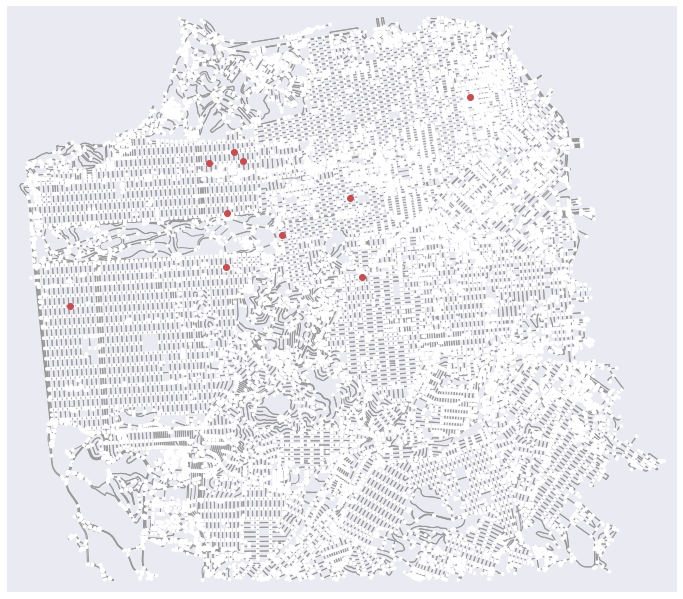

In [15]:
plt.figure(figsize=(12,12))
ax = plt.gca()
ox.plot_graph(g, ax=ax, show=False)
df.plot(ax=ax, c='r')
plt.show()

In [16]:
g[33241803][2071244784]

AtlasView({0: {'osmid': 196831109, 'oneway': True, 'name': 'Chestnut Street', 'highway': 'residential', 'length': 20.076, 'geometry': <shapely.geometry.linestring.LineString object at 0x7fe542753390>, 'speed_kph': 39.4, 'travel_time': 1.8}})

In [17]:
df.loc[:, "key"] = 0
pr = df.merge(df, on="key", suffixes=("_from", "_to"))
pr["dist"] = pr.apply(
    lambda x: nx.shortest_path_length(
        g, 
        source=x.nearest_node_from, 
        target=x.nearest_node_to,
        weight="length"
    ),
    axis=1
)
pr

,name_from,geometry_from,nearest_node_from,key,name_to,geometry_to,nearest_node_to,dist
0,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0.000
1,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0,Blue Danube Coffee House,POINT (-122.46251 37.78323),65351072,1988.177
2,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0,Diamond Coffee N Pastry,POINT (-122.47017 37.78290),65356292,2647.755
3,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0,Rise & Grind Coffee and Tea,POINT (-122.46607 37.77372),5432250152,1417.282
4,Flywheel Coffee Roasters,POINT (-122.45351 37.76968),65361720,0,The Coffee Movement,POINT (-122.41030 37.79483),65310923,5992.778
...,...,...,...,...,...,...,...,...
95,Castro Coffee Company,POINT (-122.43497 37.76219),5438557792,0,Beanery,POINT (-122.46639 37.76383),65297590,3314.838
96,Castro Coffee Company,POINT (-122.43497 37.76219),5438557792,0,Andytown Coffee Roasters,POINT (-122.50228 37.75680),65294075,6860.587
97,Castro Coffee Company,POINT (-122.43497 37.76219),5438557792,0,Not Latte,POINT (-122.46441 37.78478),65302771,4897.511
98,Castro Coffee Company,POINT (-122.43497 37.76219),5438557792,0,The Mill,POINT (-122.43775 37.77648),5433622906,1800.839


In [18]:
sg = nx.DiGraph()
sg.add_nodes_from(df.index)

In [19]:
name2node = dict(zip(df.name, df.index))
node2nn = dict(zip(df.index, df.nearest_node))
node2name = dict(zip(df.index, df.name))
for idx, row in pr.loc[pr["name_from"] != pr["name_to"]].iterrows():
    sg.add_edge(name2node[row["name_from"]], name2node[row["name_to"]], weight=row["dist"])

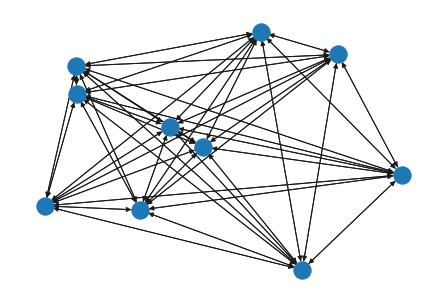

In [20]:
nx.draw(sg)

In [21]:
path = nx.approximation.traveling_salesman_problem(sg, cycle=False)
path

[4, 8, 9, 0, 5, 6, 3, 1, 7, 2]

In [46]:
[node2name[x] for x in path]

['The Coffee Movement',
 'The Mill',
 'Castro Coffee Company',
 'Flywheel Coffee Roasters',
 'Beanery',
 'Andytown Coffee Roasters',
 'Rise & Grind Coffee and Tea',
 'Blue Danube Coffee House',
 'Not Latte',
 'Diamond Coffee N Pastry']

In [23]:
full_path = []
node_path = [node2nn[x] for x in path]
for i in range(len(path) - 1):
    if i == 0:
        full_path += nx.shortest_path(g, node_path[i], node_path[i+1], weight="travel_time")
    else:
        full_path += nx.shortest_path(g, node_path[i], node_path[i+1], weight="travel_time")[1:]
len(full_path), sum([g[full_path[i]][full_path[i+1]][0]["travel_time"] for i in range(len(full_path) - 1)])/60

(275, 28.886666666666667)

In [ ]:
g[full_path[0]][full_path[1]][0]

In [ ]:
sum([g[full_path[i]][full_path[i+1]][0]["length"] for i in range(len(full_path) - 1)]) * 0.000621371

In [27]:
df.loc[:, "tweaked_geom"] = df.geometry.apply(lambda x: Point((x.xy[0][0], x.xy[1][0]+0.0013)))

In [24]:
sns.axes_style()

{'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'white',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

In [43]:
sns.set_style({"axes.facecolor": "#C6A992", "figure.facecolor": "#C6A992"}) #latte brown colorcodess.io
# sns.set_theme(font="Aharoni")

2022-09-04 17:07:25 Begin plotting the graph...
2022-09-04 17:07:28 Created edges GeoDataFrame from graph


/Users/katherinementzer/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/geopandas/plotting.py:467: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()


2022-09-04 17:07:35 Finished plotting the graph


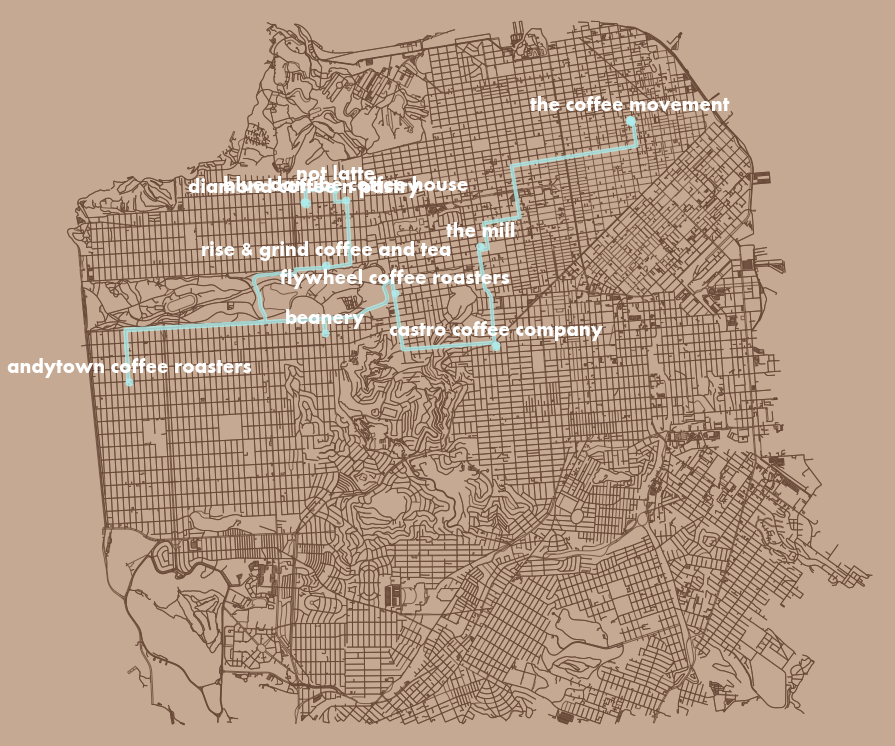

In [45]:
plt.figure(figsize=(15,15))
ax = plt.gca()
ox.plot.plot_graph(g, node_size=0, ax=ax, show=False, close=False, edge_alpha=.8, edge_color="#674736") #coffee brown
ox.plot.plot_graph_route(g, full_path, ax=ax, show=False, close=False, route_color="#AFEEEE", route_alpha=.8)
df.plot(ax=ax, c="#AFEEEE", markersize=50, alpha=.8)
font = "/Users/katherinementzer/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/Aharoni/27490885900.ttf"
df.apply(lambda x: ax.annotate(fontsize=20, text=x["name"].lower(), xy=x.tweaked_geom.coords[0], ha='center', c="white", fontweight=8), axis=1)
plt.show()

In [36]:
my_list = [g[full_path[i]][full_path[i+1]][0]["name"] for i in range(len(full_path) - 1) if "name" in g[full_path[i]][full_path[i+1]][0]]
seen = set()
seen_add = seen.add
[x for x in my_list if not (str(x) in seen or seen_add(str(x)))]

['19th Avenue',
 'Noriega Street',
 'Sunset Boulevard',
 'Lawton Street',
 '43rd Avenue',
 'Judah Street',
 '45th Avenue',
 'Lincoln Way',
 ['Crossover Drive', '19th Avenue'],
 'Crossover Drive',
 'Park Presidio Bypass Drive',
 'Fulton Street',
 '11th Avenue',
 'Stanyan Street',
 'Oak Street',
 'Divisadero Street',
 'Haight Street',
 'Grove Street',
 'Castro Street',
 'Market Street',
 'Van Ness Bus Rapid Transit',
 'Bush Street',
 'Taylor Street',
 'California Street',
 'Mason Street',
 'Washington Street']

In [30]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/System/Library/Fonts/Menlo.ttc',
 '/System/Library/Fonts/SFNSMono.ttf',
 '/System/Library/Fonts/GeezaPro.ttc',
 '/System/Library/Fonts/Supplemental/Cochin.ttc',
 '/System/Library/Fonts/ヒラギノ角ゴシック W5.ttc',
 '/System/Library/Fonts/Supplemental/Chalkboard.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansOldHungarian-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Kokonor.ttf',
 '/System/Library/Fonts/LastResort.otf',
 '/System/Library/Fonts/Supplemental/NotoSansMongolian-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Khmer Sangam MN.ttf',
 '/System/Library/Fonts/Supplemental/Georgia Italic.ttf',
 '/System/Library/Fonts/Supplemental/Sana.ttc',
 '/System/Library/Fonts/Supplemental/Didot.ttc',
 '/System/Library/Fonts/Supplemental/Beirut.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansPauCinHau-Regular.ttf',
 '/System/Library/Fonts/Supplemental/Athelas.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansCaucasianAlbanian-Regular.ttf',
 '/System/Library/Fonts/NewYork.ttf',
 '/Sy

In [33]:
fm = matplotlib.font_manager.FontManager()
fm.addfont("/Users/katherinementzer/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/Aharoni/27490885900.ttf")
# font = fm. 

In [34]:
font_dir = ["/Users/katherinementzer/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/Aharoni"]
for font in matplotlib.font_manager.findSystemFonts(font_dir):
    matplotlib.font_manager.fontManager.addfont(font)

In [35]:
from matplotlib import rcParams
rcParams['font.family'] = 'Aharoni'